In [56]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from scipy.stats import sem
import random

# Dataset

In [2]:
jerks_path = "Dataset/Human_Likeness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path = "Dataset/Human_Likeness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path = "Dataset/Human_Likeness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

labels_path = "Dataset/Human_Likeness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"

In [3]:
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})

# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
XY.drop(['Unnamed: 0_jerks','Unnamed: 0_YY','Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)

print(XY.shape) # Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + Label for MOS = 120

(320, 120)


In [4]:
XX = XY.drop(['Mean_Human_Likeness_Score'], axis=1, inplace=False)
bad_features = ['LeftShoulder_vs_LeftArm', 'LeftArm_vs_LeftForeArm', 'LeftForeArm_vs_LeftHand',
                'RightShoulder_vs_RightArm', 'RightArm_vs_RightForeArm','RightForeArm_vs_RightHand']
XX.drop(bad_features, axis=1, inplace=True)
YY = XY.loc[:,'Mean_Human_Likeness_Score']
XX = np.log(XX)
print(XX.shape)
print(YY.shape)

(320, 113)
(320,)


In [5]:
XX

,Spine1_jerks,Spine2_jerks,Spine3_jerks,LeftShoulder_jerks,LeftArm_jerks,LeftForearm_jerks,LeftHand_jerks,RightShoulder_jerks,RightArm_jerks,RightForearm_jerks,...,RightArm_vs_Head,RightForeArm_vs_Neck,RightForeArm_vs_Neck1,RightForeArm_vs_Head,RightHand_vs_Neck,RightHand_vs_Neck1,RightHand_vs_Head,Neck_vs_Neck1,Neck_vs_Head,Neck1_vs_Head
0,4.685833,5.411104,5.878632,6.194287,6.654608,7.431837,8.474055,6.194249,6.474088,7.639084,...,3.130290,3.679714,3.795530,3.909335,3.880780,3.946465,4.020627,1.957319,2.650410,1.957318
1,4.794414,5.491201,5.933963,6.253794,6.713159,7.475203,8.674891,6.253755,6.409670,7.597684,...,3.135669,3.669006,3.791143,3.909384,3.917419,3.992429,4.072623,1.957319,2.650434,1.957318
2,4.641790,5.373085,5.848681,6.152784,6.634901,7.446747,8.324778,6.152773,6.423095,7.634566,...,3.119672,3.668913,3.790845,3.908603,3.913308,3.986488,4.064947,1.957319,2.650425,1.957318
3,4.542846,5.256153,5.713922,6.057099,6.488468,7.652750,8.665599,6.057132,6.482450,8.016873,...,3.093102,3.690947,3.794171,3.899783,3.924257,3.969200,4.025873,1.957319,2.650451,1.957318
4,4.344198,5.028202,5.490168,5.835539,6.388440,7.772797,8.492025,5.835528,6.345554,8.034707,...,3.254087,3.771244,3.865813,3.964501,3.754857,3.788852,3.845917,1.957319,2.650424,1.957318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,4.967658,5.675472,6.141858,6.474946,6.803089,7.614594,8.627233,6.474991,6.756016,7.909899,...,3.188443,3.730458,3.839608,3.948081,3.863484,3.930477,4.006339,1.957319,2.650434,1.957318
316,5.223548,5.940617,6.413427,6.708183,6.957730,7.672844,8.686264,6.708236,6.932257,7.830544,...,3.196602,3.721198,3.837829,3.951216,3.959419,4.040367,4.123688,1.957319,2.650427,1.957318
317,4.905687,5.614416,6.066102,6.359770,6.649041,7.214690,8.159950,6.359816,6.534368,7.303212,...,3.176638,3.700464,3.821077,3.937587,3.860154,3.943806,4.032126,1.957319,2.650428,1.957318
318,5.095075,5.764548,6.213821,6.536927,6.922111,7.758229,8.684179,6.536952,6.871885,7.835126,...,3.207033,3.729848,3.846068,3.959066,3.963396,4.043431,4.125943,1.957319,2.650415,1.957318


107.12149997827616


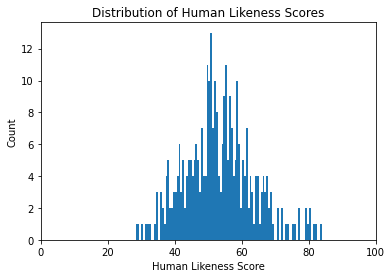

In [6]:
plt.hist(YY, bins = 100)
plt.xlim(0,100)
plt.xlabel("Human Likeness Score")
plt.ylabel("Count")
plt.title("Distribution of Human Likeness Scores")
var = np.var(YY)
print(var)

In [7]:
XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.2)

In [115]:
def learning_curve(model_name, model, XX, YY, param_grid, xticks, log_bool):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        
        inner_val_scores = []
        inner_train_scores = []
        for train_set_size in param_grid:
            val_scores = []
            train_scores = []
            inner_loop_cv = KFold(n_splits = n_splits, shuffle = True)
            inner_folds = inner_loop_cv.split(XX_train)
            for inner_train, val in inner_folds: # cross validation for the given train set size with the given train set
                train_indexes = random.sample(inner_train.tolist(), int(train_set_size))
                XX_train_reduced = XX_train.iloc[train_indexes]
                YY_train_reduced = YY_train.iloc[train_indexes]
                XX_val = XX_train.iloc[val]
                YY_val = YY_train.iloc[val]
                
                YY_train_reduced = YY_train_reduced.values.flatten()
                YY_val = YY_val.values.flatten()
                
                model.fit(XX_train_reduced, YY_train_reduced)
                val_scores = val_scores + [mean_squared_error(YY_val, np.clip(model.predict(XX_val), 0, 100), squared=True)]
                train_scores = train_scores + [mean_squared_error(YY_train_reduced, 
                                                                  np.clip(model.predict(XX_train_reduced), 0, 100),
                                                                  squared=True)]
            inner_val_scores = inner_val_scores + [np.mean(val_scores)]
            inner_train_scores = inner_train_scores + [np.mean(train_scores)]
        outer_val_mse = outer_val_mse + [inner_val_scores]
        outer_train_mse = outer_train_mse + [inner_train_scores]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)

    plt.figure(figsize=(6,4))
    plt.plot(param_grid, mean_train_mse, label='MSE on Training Set')
    plt.plot(param_grid, mean_val_mse, label='MSE on Validation Set')
    plt.xlim(min(param_grid), max(param_grid))
    if (log_bool == False):
        plt.xticks(xticks)
    if (log_bool == True):
        plt.xscale('log')
    plt.ylim(0, max(mean_val_mse) + max(mean_val_mse)*0.05)
    plt.ylabel('MSE')
    plt.xlabel('Number of Observations in the Training Set')
    plt.title(model_name + ' performance\n on different Training Set sizes')
    plt.legend()
    
    print('Best Training Set Size: ', int(param_grid[np.where(mean_val_mse == (min(mean_val_mse)))[0]]))

In [88]:
def validation_curve(model_name, model, XX, YY, param_grid, log_bool, extra_string, xticks):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        YY_train = YY_train.values.flatten()
        
        cv_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "neg_mean_squared_error", 
                                    cv = KFold(n_splits = 5, shuffle = True), return_train_score=True)
        cv_model.fit(XX_train, YY_train)
        
        train_mse = -1 * cv_model.cv_results_["mean_train_score"]
        val_mse = -1 * cv_model.cv_results_["mean_test_score"]
        
        outer_train_mse = outer_train_mse + [train_mse]
        outer_val_mse = outer_val_mse + [val_mse]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    
    train_mse_sem = sem(np.asarray(outer_train_mse), axis=0)
    val_mse_sem = sem(np.asarray(outer_val_mse), axis=0)
    
    param_list = list(np.concatenate(list(param_grid.values())).flat)
    
    plt.figure(figsize = (6,4))
    plt.plot(param_list, mean_train_mse, label='Training Set MSE')
    plt.fill_between(param_list, mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(param_list, mean_val_mse, label='Validation Set MSE')
    plt.fill_between(param_list, mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    if log_bool == True:
        plt.xscale('log')
    plt.xlim(min(param_list),max(param_list))
    plt.xticks(xticks)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.ylabel('MSE')
    plt.xlabel(list(param_grid.keys())[0])
    plt.title(model_name + ' performance on varying ' + list(param_grid.keys())[0] + extra_string)
    plt.legend()
    

In [89]:
# Model name is just the type of algorithm e.g. Linear Regression or kNN
def predicted_vs_true(model_name, model, XX, YY):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    folds = outer_loop_cv.split(XX)
    count = 1
    YY_train_true = []
    YY_train_preds = []
    YY_preds = []
    YY_true = []
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        XX_test= XX.iloc[test]
        YY_test = YY.iloc[test]
        YY_train, YY_test = YY_train.values.flatten(), YY_test.values.flatten()
        
        model.fit(XX_train, YY_train)
        
        YY_train_preds = YY_train_preds + list(model.predict(XX_train))
        YY_train_true = YY_train_true + list(YY_train)
        
        YY_pred = model.predict(XX_test)
        
        YY_true = YY_true + list(YY_test)
        YY_preds = YY_preds + list(YY_pred)
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
    
    
    m, b = np.polyfit(YY_preds, YY_true, 1)
    x = np.arange(0,101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.scatter(YY_preds, YY_true, s=7.5, alpha=0.8, label='Predictions')
    plt.plot(x, y*m + b, '-c', label="Regression Line for predictions")
    plt.plot(x, y, "-k", label="Regression Line for p=1", alpha=0.5)
    plt.title("Predictions of " + model_name + " Model on Test Set")
    plt.ylabel("True Human-Likeness")
    plt.xlabel("Predicted Human-Likeness")
    plt.xticks(np.linspace(0,100,11))
    plt.yticks(np.linspace(0,100,11))
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()

    rho, pval = stats.spearmanr(YY_true, YY_preds)
    print("Pearson Correlation Coefficient =", rho)
    print("Test Mean Squared Error = ", mean_squared_error(YY_true, YY_preds, squared=True))
    print("Train Mean Squared Error = ", mean_squared_error(YY_train_true, YY_train_preds, squared=True))

# SVR

Learning Curves

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Training Set Size:  204
Time taken:  86.41043853759766


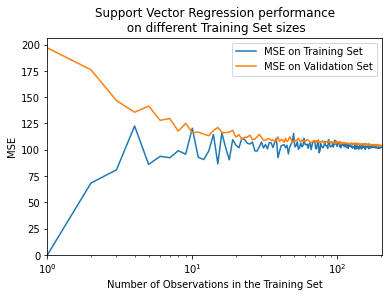

In [116]:
start_time = time.time()
svr = SVR(kernel = "rbf", cache_size=7000)
# No hyperparameter tuning since it would take far too long
learning_curve('Support Vector Regression', svr, XX, YY, np.linspace(1,204,204), np.linspace(0,200,9), True)
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Training Set Size:  192
Time taken:  77.99779200553894


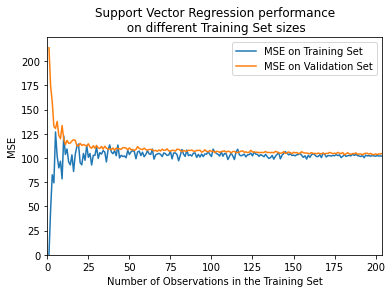

In [117]:
start_time = time.time()
svr = SVR(kernel = "rbf", cache_size=7000)
# No hyperparameter tuning since it would take far too long
learning_curve('Support Vector Regression', svr, XX, YY, np.linspace(1,204,204), np.linspace(0,200,9), False)
print("Time taken: ", time.time() - start_time)

Grid Search Cross Validation for Hyperparameter Tuning

In [90]:
start_time = time.time()

param_grid = {"C": np.logspace(-3, 6, num=10), "gamma": np.logspace(-9, 4, num=14), "epsilon": np.logspace(-3, 6, num=10)}

svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error")

svr.fit(XX_train, YY_train)

svr_init_params = svr.best_params_

print("Time taken: ", time.time() - start_time)

Time taken:  167.69981813430786


In [91]:
print(svr.best_params_)

{'C': 100.0, 'epsilon': 1.0, 'gamma': 0.1}


Finer Hyperparameter tuning

Tuning epsilon

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  154.38018488883972


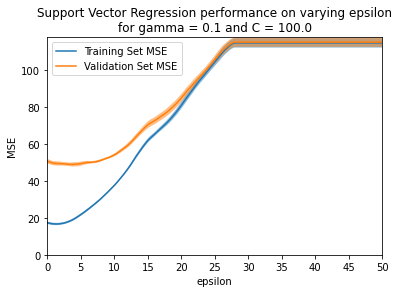

In [92]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], C = svr_init_params['C'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"epsilon": np.linspace(0, 50, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY, param_grid, False, extra_string, np.linspace(0, 50, num=11))
print("Time taken: ", time.time() - start_time)

Tuning gamma

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  306.39315485954285


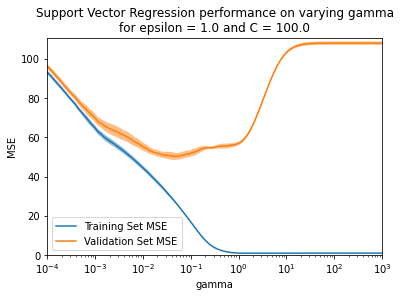

In [93]:
start_time = time.time()
svr = SVR(kernel = "rbf", epsilon = svr_init_params['epsilon'], C = svr_init_params['C'])
extra_string = '\nfor epsilon = ' + str(svr_init_params['epsilon']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"gamma": np.logspace(-4, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY, param_grid, True, extra_string, np.logspace(-4, 3, num=8))
print("Time taken: ", time.time() - start_time)

Tuning C

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  277.5851447582245


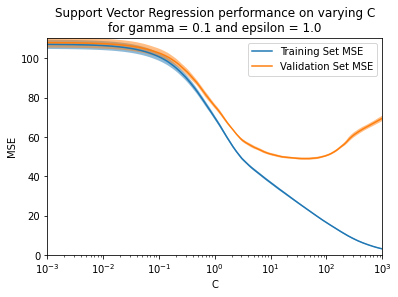

In [94]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], epsilon = svr_init_params['epsilon'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and epsilon = ' + str(svr_init_params['epsilon'])
param_grid = {"C": np.logspace(-3, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY, param_grid, True, extra_string, np.logspace(-3, 3, num=7))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7383014998141658
Test Mean Squared Error =  45.86269945275206
Train Mean Squared Error =  25.72061115630705
Time taken:  1600.1161437034607


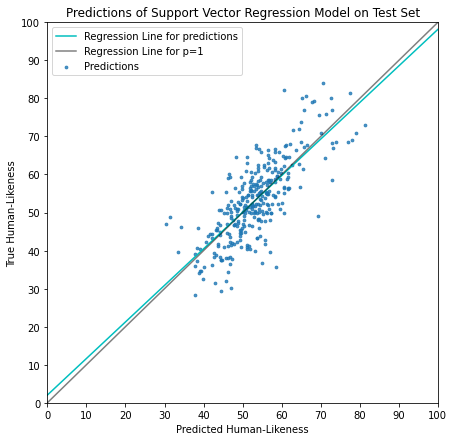

In [95]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"C": np.logspace(-3, 4, num=20), "gamma": np.logspace(-4, 2, num=20), "epsilon": np.linspace(0, 50, num=20)}
svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Support Vector Regression', svr, XX, YY)
print("Time taken: ", time.time() - start_time)

# Linear Regression

Learning Curves

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Training Set Size:  201
Time taken:  159.45245838165283


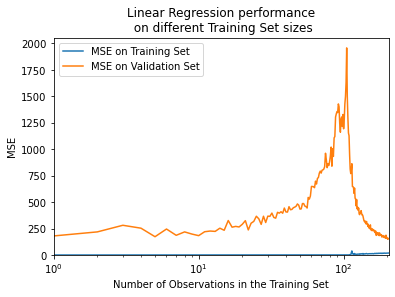

In [118]:
start_time = time.time()
learning_curve('Linear Regression', LinearRegression(), XX, YY, np.linspace(1,204,204), np.linspace(0,200,9), True)
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Training Set Size:  193
Time taken:  161.64144349098206


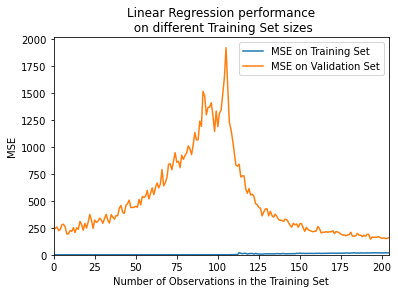

In [119]:
start_time = time.time()
learning_curve('Linear Regression', LinearRegression(), XX, YY, np.linspace(1,204,204), np.linspace(0,200,9), False)
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.5496142406579723
Test Mean Squared Error =  133.8380869445146
Train Mean Squared Error =  25.26073173953939
Time taken:  0.22112631797790527


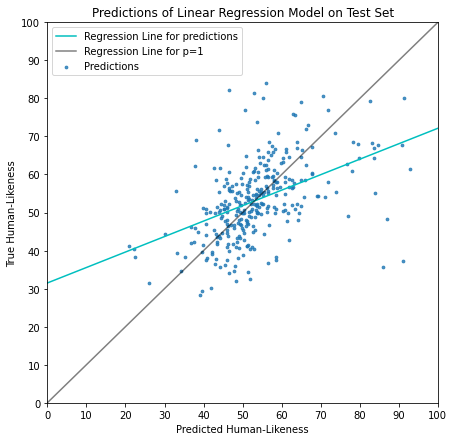

In [96]:
start_time = time.time()
predicted_vs_true('Linear Regression', LinearRegression(), XX, YY)
print("Time taken: ", time.time() - start_time)

# Ridge Regression

Learning Curves

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Training Set Size:  204
Time taken:  68.50051593780518


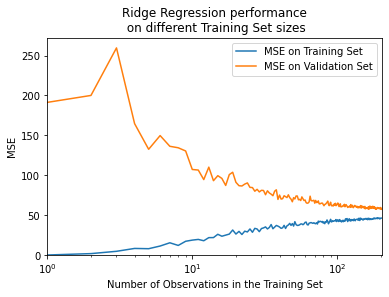

In [120]:
start_time = time.time()
learning_curve('Ridge Regression', Ridge(), XX, YY, np.linspace(1,204,204), np.linspace(0,200,9), True)
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Training Set Size:  183
Time taken:  68.65406084060669


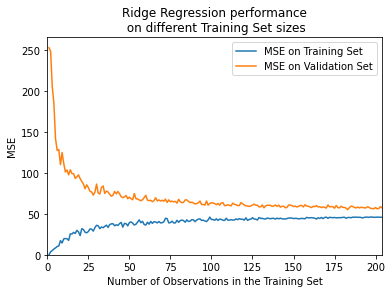

In [121]:
start_time = time.time()
learning_curve('Ridge Regression', Ridge(), XX, YY, np.linspace(1,204,204), np.linspace(0,200,9), False)
print("Time taken: ", time.time() - start_time)

Tuning alpha

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  304.4812071323395


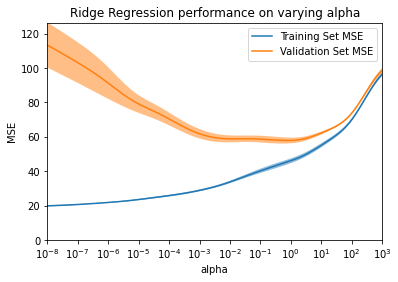

In [97]:
start_time = time.time()
validation_curve('Ridge Regression', Ridge(), XX, YY, {"alpha": np.logspace(-8,3, 1000)}, True, '', np.logspace(-8,3,12))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.6734551278026284
Test Mean Squared Error =  56.60115827574856
Train Mean Squared Error =  47.21257226934743
Time taken:  204.51629447937012


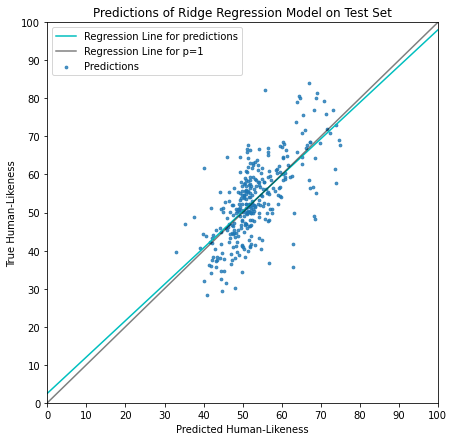

In [98]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-8,3, 1000)}
ridge_model = GridSearchCV(estimator = Ridge(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Ridge Regression', ridge_model, XX, YY)
print("Time taken: ", time.time() - start_time)

# Kernel Ridge Regression

Learning Curves

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Training Set Size:  202
Time taken:  93.55675387382507


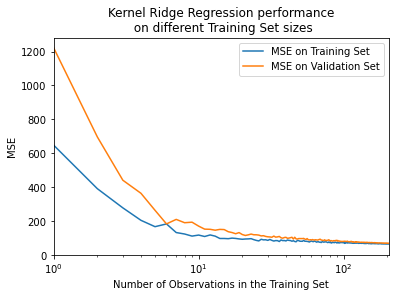

In [122]:
start_time = time.time()
learning_curve('Kernel Ridge Regression', KernelRidge(kernel = "rbf"), XX, YY, np.linspace(1,204,204),
               np.linspace(0,200,9), True)
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Training Set Size:  201
Time taken:  91.24095702171326


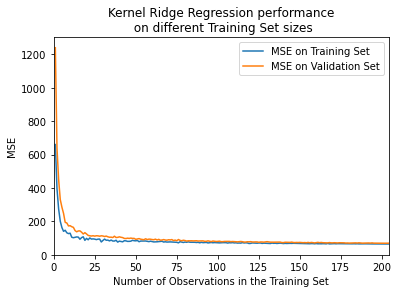

In [123]:
start_time = time.time()
learning_curve('Kernel Ridge Regression', KernelRidge(kernel = "rbf"), XX, YY, np.linspace(1,204,204),
               np.linspace(0,200,9), False)
print("Time taken: ", time.time() - start_time)

Grid Search for hyperparameter intialisations

In [99]:
start_time = time.time()

param_grid = {"alpha": np.logspace(-10,5, 16), "gamma": np.logspace(-10, 5, 16)}
kfolds = KFold(n_splits = 5, shuffle = True)
krr = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv=kfolds, verbose = 3)
krr.fit(XX_train, YY_train)

krr_init_params = krr.best_params_
print("Time taken: ", time.time() - start_time)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=1e-

[CV 4/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 5/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 1/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 2/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 3/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 4/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 5/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 1/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 2/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 3/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 4/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 5/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 1/5] END ...............

[CV 3/5] END ........................alpha=1e-08, gamma=10.0; total time=   0.0s
[CV 4/5] END ........................alpha=1e-08, gamma=10.0; total time=   0.0s
[CV 5/5] END ........................alpha=1e-08, gamma=10.0; total time=   0.0s
[CV 1/5] END .......................alpha=1e-08, gamma=100.0; total time=   0.0s
[CV 2/5] END .......................alpha=1e-08, gamma=100.0; total time=   0.0s
[CV 3/5] END .......................alpha=1e-08, gamma=100.0; total time=   0.0s
[CV 4/5] END .......................alpha=1e-08, gamma=100.0; total time=   0.0s
[CV 5/5] END .......................alpha=1e-08, gamma=100.0; total time=   0.0s
[CV 1/5] END ......................alpha=1e-08, gamma=1000.0; total time=   0.0s
[CV 2/5] END ......................alpha=1e-08, gamma=1000.0; total time=   0.0s
[CV 3/5] END ......................alpha=1e-08, gamma=1000.0; total time=   0.0s
[CV 4/5] END ......................alpha=1e-08, gamma=1000.0; total time=   0.0s
[CV 5/5] END ...............

[CV 1/5] END .......................alpha=1e-06, gamma=1e-10; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=1e-10; total time=   0.0s
[CV 3/5] END .......................alpha=1e-06, gamma=1e-10; total time=   0.0s
[CV 4/5] END .......................alpha=1e-06, gamma=1e-10; total time=   0.0s
[CV 5/5] END .......................alpha=1e-06, gamma=1e-10; total time=   0.0s
[CV 1/5] END .......................alpha=1e-06, gamma=1e-09; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=1e-09; total time=   0.0s
[CV 3/5] END .......................alpha=1e-06, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=1e-06, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=1e-06, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=1e-06, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=1e-08; total time=   0.0s
[CV 3/5] END ...............

[CV 2/5] END .......................alpha=1e-05, gamma=1e-05; total time=   0.0s
[CV 3/5] END .......................alpha=1e-05, gamma=1e-05; total time=   0.0s
[CV 4/5] END .......................alpha=1e-05, gamma=1e-05; total time=   0.0s
[CV 5/5] END .......................alpha=1e-05, gamma=1e-05; total time=   0.0s
[CV 1/5] END ......................alpha=1e-05, gamma=0.0001; total time=   0.0s
[CV 2/5] END ......................alpha=1e-05, gamma=0.0001; total time=   0.0s
[CV 3/5] END ......................alpha=1e-05, gamma=0.0001; total time=   0.0s
[CV 4/5] END ......................alpha=1e-05, gamma=0.0001; total time=   0.0s
[CV 5/5] END ......................alpha=1e-05, gamma=0.0001; total time=   0.0s
[CV 1/5] END .......................alpha=1e-05, gamma=0.001; total time=   0.0s
[CV 2/5] END .......................alpha=1e-05, gamma=0.001; total time=   0.0s
[CV 3/5] END .......................alpha=1e-05, gamma=0.001; total time=   0.0s
[CV 4/5] END ...............

[CV 5/5] END .......................alpha=0.0001, gamma=10.0; total time=   0.0s
[CV 1/5] END ......................alpha=0.0001, gamma=100.0; total time=   0.0s
[CV 2/5] END ......................alpha=0.0001, gamma=100.0; total time=   0.0s
[CV 3/5] END ......................alpha=0.0001, gamma=100.0; total time=   0.0s
[CV 4/5] END ......................alpha=0.0001, gamma=100.0; total time=   0.0s
[CV 5/5] END ......................alpha=0.0001, gamma=100.0; total time=   0.0s
[CV 1/5] END .....................alpha=0.0001, gamma=1000.0; total time=   0.0s
[CV 2/5] END .....................alpha=0.0001, gamma=1000.0; total time=   0.0s
[CV 3/5] END .....................alpha=0.0001, gamma=1000.0; total time=   0.0s
[CV 4/5] END .....................alpha=0.0001, gamma=1000.0; total time=   0.0s
[CV 5/5] END .....................alpha=0.0001, gamma=1000.0; total time=   0.0s
[CV 1/5] END ....................alpha=0.0001, gamma=10000.0; total time=   0.0s
[CV 2/5] END ...............

[CV 2/5] END ........................alpha=0.01, gamma=1e-09; total time=   0.0s
[CV 3/5] END ........................alpha=0.01, gamma=1e-09; total time=   0.0s
[CV 4/5] END ........................alpha=0.01, gamma=1e-09; total time=   0.0s
[CV 5/5] END ........................alpha=0.01, gamma=1e-09; total time=   0.0s
[CV 1/5] END ........................alpha=0.01, gamma=1e-08; total time=   0.0s
[CV 2/5] END ........................alpha=0.01, gamma=1e-08; total time=   0.0s
[CV 3/5] END ........................alpha=0.01, gamma=1e-08; total time=   0.0s
[CV 4/5] END ........................alpha=0.01, gamma=1e-08; total time=   0.0s
[CV 5/5] END ........................alpha=0.01, gamma=1e-08; total time=   0.0s
[CV 1/5] END ........................alpha=0.01, gamma=1e-07; total time=   0.0s
[CV 2/5] END ........................alpha=0.01, gamma=1e-07; total time=   0.0s
[CV 3/5] END ........................alpha=0.01, gamma=1e-07; total time=   0.0s
[CV 4/5] END ...............

[CV 5/5] END ..........................alpha=0.1, gamma=0.01; total time=   0.0s
[CV 1/5] END ...........................alpha=0.1, gamma=0.1; total time=   0.0s
[CV 2/5] END ...........................alpha=0.1, gamma=0.1; total time=   0.0s
[CV 3/5] END ...........................alpha=0.1, gamma=0.1; total time=   0.0s
[CV 4/5] END ...........................alpha=0.1, gamma=0.1; total time=   0.0s
[CV 5/5] END ...........................alpha=0.1, gamma=0.1; total time=   0.0s
[CV 1/5] END ...........................alpha=0.1, gamma=1.0; total time=   0.0s
[CV 2/5] END ...........................alpha=0.1, gamma=1.0; total time=   0.0s
[CV 3/5] END ...........................alpha=0.1, gamma=1.0; total time=   0.0s
[CV 4/5] END ...........................alpha=0.1, gamma=1.0; total time=   0.0s
[CV 5/5] END ...........................alpha=0.1, gamma=1.0; total time=   0.0s
[CV 1/5] END ..........................alpha=0.1, gamma=10.0; total time=   0.0s
[CV 2/5] END ...............

[CV 4/5] END ........................alpha=1.0, gamma=1000.0; total time=   0.0s
[CV 5/5] END ........................alpha=1.0, gamma=1000.0; total time=   0.0s
[CV 1/5] END .......................alpha=1.0, gamma=10000.0; total time=   0.0s
[CV 2/5] END .......................alpha=1.0, gamma=10000.0; total time=   0.0s
[CV 3/5] END .......................alpha=1.0, gamma=10000.0; total time=   0.0s
[CV 4/5] END .......................alpha=1.0, gamma=10000.0; total time=   0.0s
[CV 5/5] END .......................alpha=1.0, gamma=10000.0; total time=   0.0s
[CV 1/5] END ......................alpha=1.0, gamma=100000.0; total time=   0.0s
[CV 2/5] END ......................alpha=1.0, gamma=100000.0; total time=   0.0s
[CV 3/5] END ......................alpha=1.0, gamma=100000.0; total time=   0.0s
[CV 4/5] END ......................alpha=1.0, gamma=100000.0; total time=   0.0s
[CV 5/5] END ......................alpha=1.0, gamma=100000.0; total time=   0.0s
[CV 1/5] END ...............

[CV 1/5] END .......................alpha=100.0, gamma=1e-05; total time=   0.0s
[CV 2/5] END .......................alpha=100.0, gamma=1e-05; total time=   0.0s
[CV 3/5] END .......................alpha=100.0, gamma=1e-05; total time=   0.0s
[CV 4/5] END .......................alpha=100.0, gamma=1e-05; total time=   0.0s
[CV 5/5] END .......................alpha=100.0, gamma=1e-05; total time=   0.0s
[CV 1/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 2/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 3/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 4/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 5/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 1/5] END .......................alpha=100.0, gamma=0.001; total time=   0.0s
[CV 2/5] END .......................alpha=100.0, gamma=0.001; total time=   0.0s
[CV 3/5] END ...............

[CV 2/5] END .......................alpha=1000.0, gamma=10.0; total time=   0.0s
[CV 3/5] END .......................alpha=1000.0, gamma=10.0; total time=   0.0s
[CV 4/5] END .......................alpha=1000.0, gamma=10.0; total time=   0.0s
[CV 5/5] END .......................alpha=1000.0, gamma=10.0; total time=   0.0s
[CV 1/5] END ......................alpha=1000.0, gamma=100.0; total time=   0.0s
[CV 2/5] END ......................alpha=1000.0, gamma=100.0; total time=   0.0s
[CV 3/5] END ......................alpha=1000.0, gamma=100.0; total time=   0.0s
[CV 4/5] END ......................alpha=1000.0, gamma=100.0; total time=   0.0s
[CV 5/5] END ......................alpha=1000.0, gamma=100.0; total time=   0.0s
[CV 1/5] END .....................alpha=1000.0, gamma=1000.0; total time=   0.0s
[CV 2/5] END .....................alpha=1000.0, gamma=1000.0; total time=   0.0s
[CV 3/5] END .....................alpha=1000.0, gamma=1000.0; total time=   0.0s
[CV 4/5] END ...............

[CV 4/5] END ....................alpha=100000.0, gamma=1e-09; total time=   0.0s
[CV 5/5] END ....................alpha=100000.0, gamma=1e-09; total time=   0.0s
[CV 1/5] END ....................alpha=100000.0, gamma=1e-08; total time=   0.0s
[CV 2/5] END ....................alpha=100000.0, gamma=1e-08; total time=   0.0s
[CV 3/5] END ....................alpha=100000.0, gamma=1e-08; total time=   0.0s
[CV 4/5] END ....................alpha=100000.0, gamma=1e-08; total time=   0.0s
[CV 5/5] END ....................alpha=100000.0, gamma=1e-08; total time=   0.0s
[CV 1/5] END ....................alpha=100000.0, gamma=1e-07; total time=   0.0s
[CV 2/5] END ....................alpha=100000.0, gamma=1e-07; total time=   0.0s
[CV 3/5] END ....................alpha=100000.0, gamma=1e-07; total time=   0.0s
[CV 4/5] END ....................alpha=100000.0, gamma=1e-07; total time=   0.0s
[CV 5/5] END ....................alpha=100000.0, gamma=1e-07; total time=   0.0s
[CV 1/5] END ...............

In [100]:
print(krr_init_params)

{'alpha': 0.01, 'gamma': 0.01}


Tuning Alpha

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  379.79543828964233


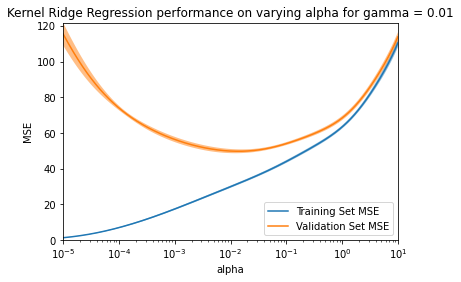

In [101]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", gamma = krr_init_params['gamma'])
extra_string = ' for gamma = ' + str(krr_init_params['gamma'])
param_grid = {"alpha": np.logspace(-5, 1, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY, param_grid, True, extra_string, np.logspace(-5,1, 7))
print("Time taken: ", time.time() - start_time)

Tuning Gamma

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  394.3774871826172


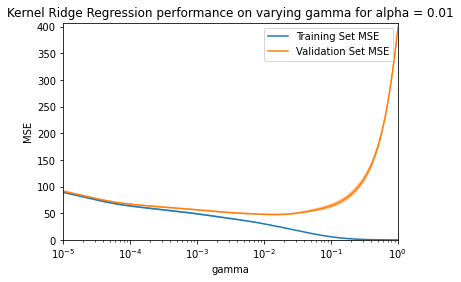

In [102]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", alpha = krr_init_params['alpha'])
extra_string = ' for alpha = ' + str(krr_init_params['alpha'])
param_grid = {"gamma": np.logspace(-5, 0, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY, param_grid, True, extra_string, np.logspace(-5,0, 6))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7261739333127761
Test Mean Squared Error =  46.52492846999212
Train Mean Squared Error =  29.128046578926888
Time taken:  815.2561447620392


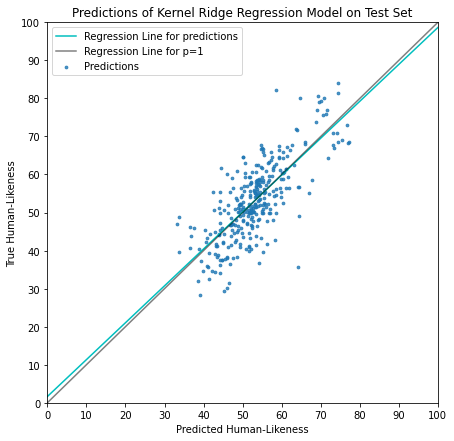

In [103]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-5, 1, 50), "gamma": np.logspace(-5, 0, 50)}
krr_model = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Kernel Ridge Regression', krr_model, XX, YY)
print("Time taken: ", time.time() - start_time)

# kNN Regression

Learning Curves

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Training Set Size:  161
Time taken:  93.80916333198547


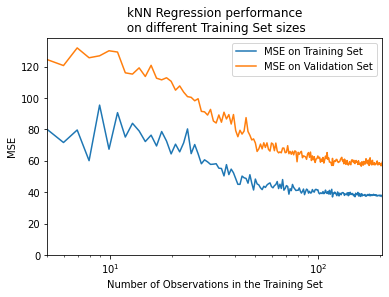

In [126]:
start_time = time.time()
learning_curve('kNN Regression', KNeighborsRegressor(), XX, YY, np.linspace(5,204,204), np.linspace(5,195,11), True)
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Training Set Size:  196
Time taken:  74.83898425102234


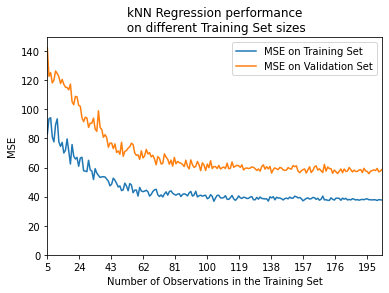

In [125]:
start_time = time.time()
learning_curve('kNN Regression', KNeighborsRegressor(), XX, YY, np.linspace(5,204,204), np.linspace(5,195,11), False)
print("Time taken: ", time.time() - start_time)

Tune n_neighbors for weights = "uniform"

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  14.430525779724121


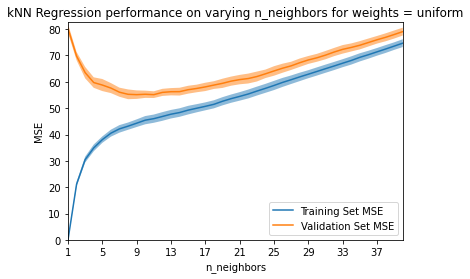

In [104]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'uniform')
extra_string = ' for weights = uniform'
param_grid = {"n_neighbors": np.arange(1,41,1)}
validation_curve('kNN Regression', knn, XX, YY, param_grid, False, extra_string, np.arange(1,41,4))
print("Time taken: ", time.time() - start_time)

Tune n_neighbors for weights = "distance"

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  14.603047609329224


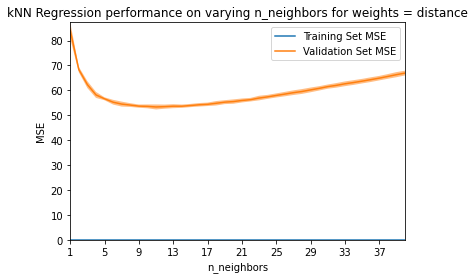

In [105]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'distance')
extra_string = ' for weights = distance'
param_grid = {"n_neighbors": np.arange(1,41,1)}
validation_curve('kNN Regression', knn, XX, YY, param_grid, False, extra_string, np.arange(1,41,4))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.6970391723402007
Test Mean Squared Error =  53.56808292284656
Train Mean Squared Error =  5.643915079600533e-10
Time taken:  17.49398136138916


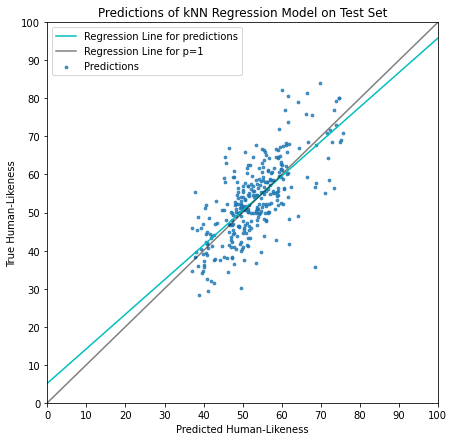

In [106]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"n_neighbors": np.arange(1,41,1), "weights": ["uniform", "distance"]}
knn_model = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('kNN Regression', knn_model, XX, YY)
print("Time taken: ", time.time() - start_time)

In [107]:
knn_model.best_params_

{'n_neighbors': 7, 'weights': 'distance'}